In [1]:
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS as stopwords_wc
import re
import numpy as np
from glob import glob

In [24]:
folderpath = "../../Data/QMEF/ILIAS_Elon_Musk_Tweets/"

In [44]:
print(df['UTC'].max())
print(df['UTC'].min())
print(df['TweetType'].unique())

2021-05-16 05:56:47+00:00
2020-10-28 00:16:43+00:00
['Reply' 'Tweet' 'Retweet']


In [25]:
df = None
for filename in glob(folderpath+"*.txt"):
    if df is None:
        df = pd.read_csv(filename, sep="\t")
        continue
    df = pd.concat([df, pd.read_csv(filename, sep="\t")])
df.set_index('TweetId')

,Text,Name,ScreenName,UTC,CreatedAt,Favorites,Retweets,Language,Client,TweetType,URLs,Hashtags,Mentions,MediaType,MediaURLs
TweetId,,,,,,,,,,,,,,,
1321513255332941824,@MachinePix Little crane: “Am I just a toy to ...,Elon Musk,elonmusk,2020-10-28T18:04:47.000Z,Wed Oct 28 18:04:47 +0000 2020,1762,52,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,1,NaN,
1331745833629470722,@EvaFoxU We will have special colors for new R...,Elon Musk,elonmusk,2020-11-25T23:45:24.000Z,Wed Nov 25 23:45:24 +0000 2020,3820,143,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,1,NaN,
1349459692515434502,@NASASpaceflight Sea shanty tiktok takes it to...,Elon Musk,elonmusk,2021-01-13T20:53:57.000Z,Wed Jan 13 20:53:57 +0000 2021,4237,140,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,1,NaN,
1390920049372897281,@ericrihlmann @Tesla @nbcsnl @TimesSquareNYC @...,Elon Musk,elonmusk,2021-05-08T06:42:36.000Z,Sat May 08 06:42:36 +0000 2021,13486,480,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,5,NaN,
1390839584225955847,Cybertruck prototype in New York this weekend,Elon Musk,elonmusk,2021-05-08T01:22:52.000Z,Sat May 08 01:22:52 +0000 2021,272338,16591,en,"<a href=""http://twitter.com/download/iphone"" r...",Tweet,NaN,0,0,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391164130204192771,@flcnhvy Might still need a VPN in some countries,Elon Musk,elonmusk,2021-05-08T22:52:29.000Z,Sat May 08 22:52:29 +0000 2021,11331,659,en,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,0,1,NaN,
1391130755787599881,Special link to view SNL outside USA https://t...,Elon Musk,elonmusk,2021-05-08T20:39:52.000Z,Sat May 08 20:39:52 +0000 2021,175011,27144,en,"<a href=""http://twitter.com/download/iphone"" r...",Tweet,https://m.youtube.com/watch?v=VJX9ymv_vUQ&feat...,0,0,NaN,
1390955387654914052,First time a Falcon rocket booster will reach ...,Elon Musk,elonmusk,2021-05-08T09:03:01.000Z,Sat May 08 09:03:01 +0000 2021,95974,6651,en,"<a href=""http://twitter.com/download/iphone"" r...",Tweet,https://twitter.com/spacex/status/139084323233...,0,0,NaN,


In [26]:
# Some tweets are longer than one line. The line break character \n gets misinterpreted as new tweet. Replace all \n with white space but the first one.
# for filename in os.listdir(folderpath):
#     with open(os.path.join(folderpath,filename), 'r', encoding='latin1') as file:
#         before, first, after = file.read().partition('\n')
#         result = before + first + after.replace('\n', ' ')
#     with open(os.path.join(folderpath,filename), 'w', encoding='latin1') as file:
#         file.write(result)

In [27]:
# Iterate through all tweets and append them to a pandas DataFrame
# Could use further optimization - Runtime 10 seconds.
# for filename in os.listdir(folderpath):
#     df = pd.concat([df, pd.read_csv(os.path.join(folderpath,filename), encoding='utf8', sep='\t')], axis=0)

In [28]:
# Correcting the Data Types
df['UTC'] = pd.to_datetime(df['UTC'], utc=True)
df['CreatedAt'] = pd.to_datetime(df['CreatedAt'], utc=True)
df['Text'] = df['Text'].apply(lambda x: str(x))
df.dtypes

TweetId                     int64
Text                       object
Name                       object
ScreenName                 object
UTC           datetime64[ns, UTC]
CreatedAt     datetime64[ns, UTC]
Favorites                   int64
Retweets                    int64
Language                   object
Client                     object
TweetType                  object
URLs                       object
Hashtags                    int64
Mentions                    int64
MediaType                  object
MediaURLs                  object
dtype: object

In [29]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    vs = analyzer.polarity_scores(text)
    return [vs['neg'], vs['pos'], vs['neu'], vs['compound']]

df[['neg', 'pos', 'neu', 'compound']] = df.apply(lambda x: get_sentiment(str(x['Text'])),result_type='expand', axis=1)

In [51]:
keywords = ['doge', 'crypto', 'bitcoin', 'btc']
doge_keywords = ['crypto']

def get_crypto_boolean(text):
    text = text.lower()
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    if any(word in text for word in doge_keywords):
        return True
    return False

df['crypto related'] = df.apply(lambda x: get_crypto_boolean(str(x['Text'])), result_type='expand', axis = 1)

# Extra column for the year
df['year'] = df["UTC"].apply(lambda x: int(str(x).split("-")[0]))

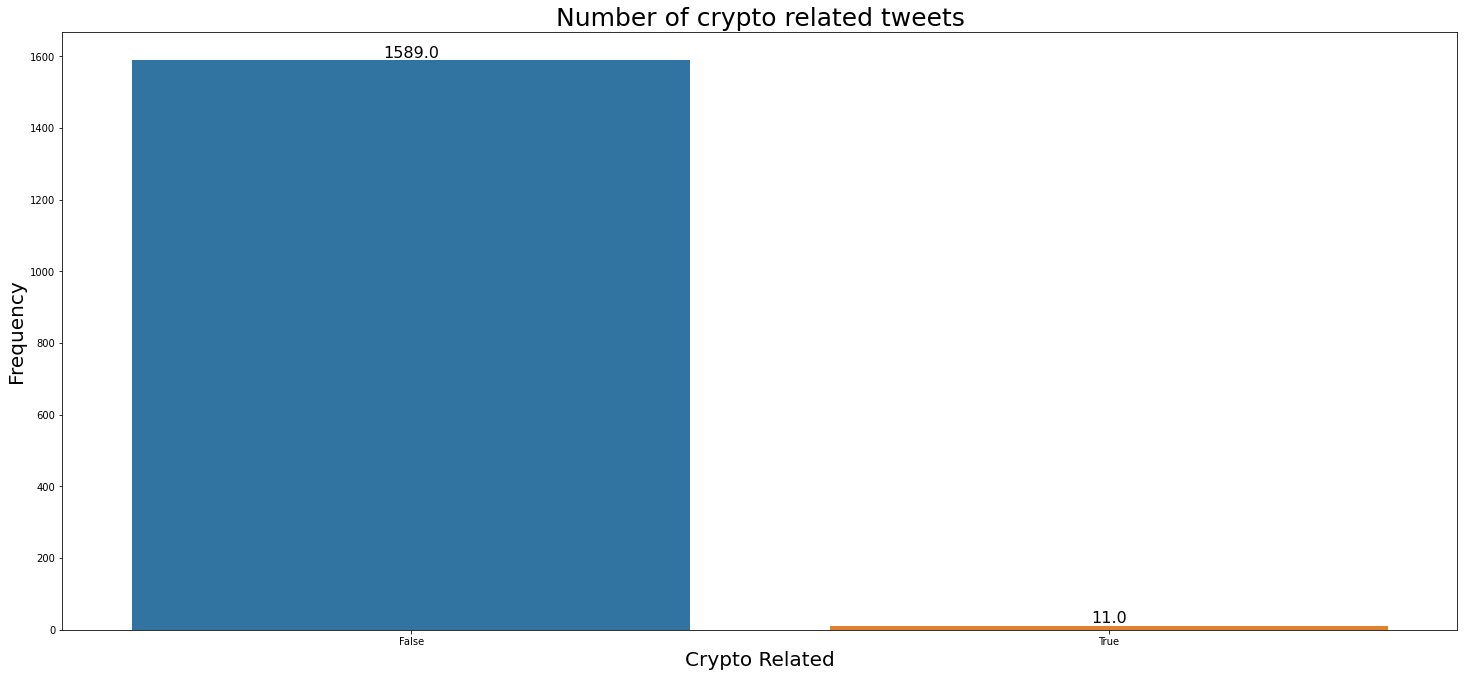

In [52]:
# Crypto related
date_count_df = df.groupby('crypto related')["TweetId"].count().reset_index()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.barplot(data=date_count_df, x='crypto related', y="TweetId")
plt.title("Number of crypto related tweets", size=25)
plt.xlabel("Crypto Related", size=20)
plt.ylabel("Frequency", size=20)

# Add annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=16)

plt.show()

[2020 2021]


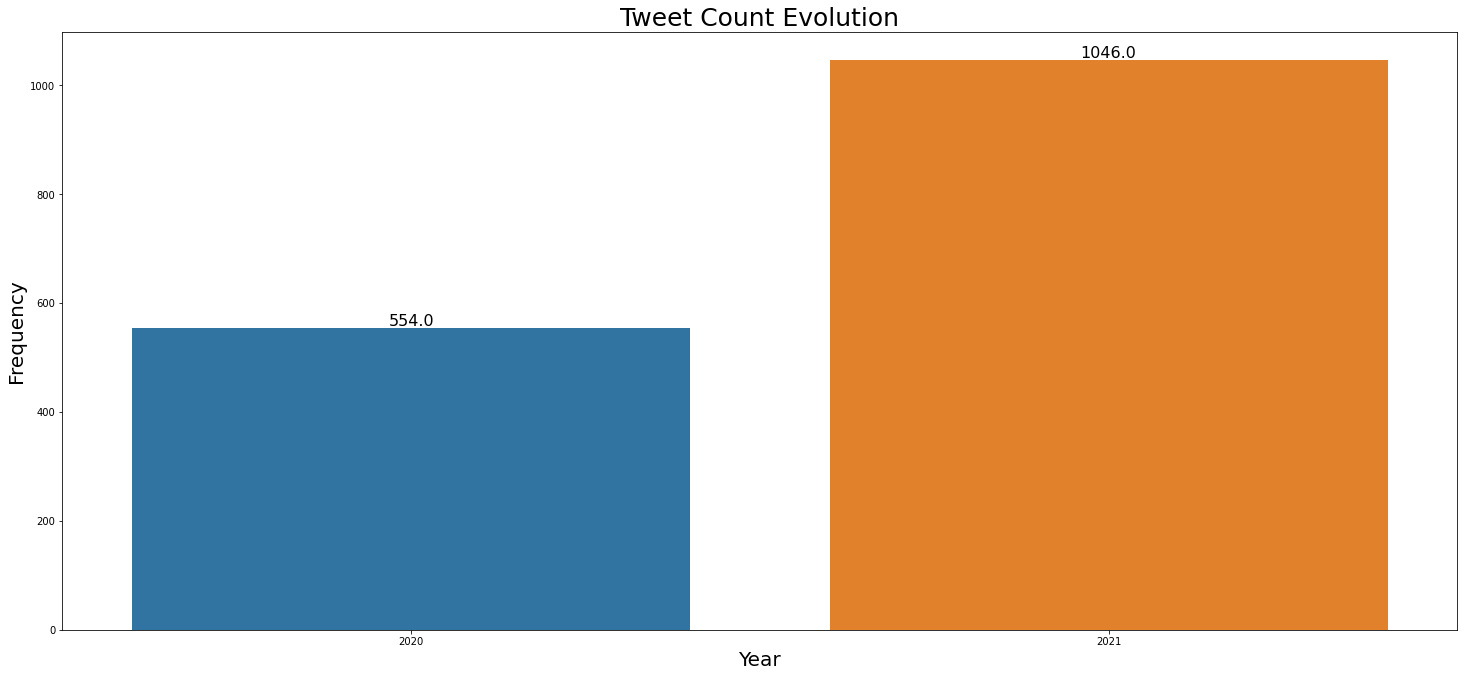

In [53]:
# Yearly evolution
date_count_df = df.groupby("year")["TweetId"].count().reset_index()
print(df['year'].unique())
# We can see that all of the 1600 Tweets are from 2020 and 2021. We can think about increasing the tweet-sample size. 
# Unfortunatly Twitter has recently updated their API and it is more cumbersome to scrape tweets. 

# Plot
plt.figure(figsize=(25, 11))
ax = sns.barplot(data=date_count_df, x="year", y="TweetId")
plt.title("Tweet Count Evolution", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Frequency", size=20)

# Add annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=16)

plt.show()

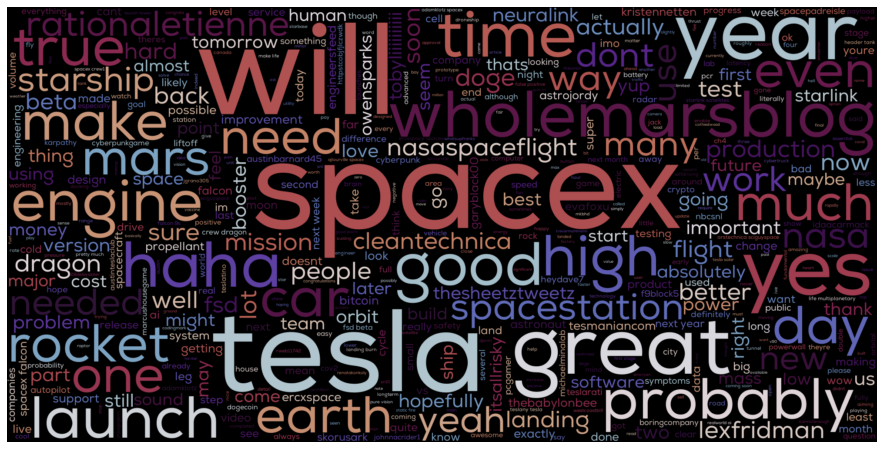

In [33]:
# Make worldcloud
# https://www.datacamp.com/tutorial/wordcloud-python
all_tweets = " ".join(token.lower() for token in df["Text"])
# all_tweets = [re.sub(r'@\w+', "", word) for word in all_tweets.split()]
all_tweets = [re.sub(r"[^a-zA-Z0-9 ]", "", word) for word in all_tweets.split()]
all_tweets = [item for item in all_tweets if item not in ['https', 't', 'amp', 'u', 'rt', 'ppathole', 'flcnhvy', 'erdayastronaut', 'teslaownerssv']]
all_tweets = " ".join(token for token in all_tweets)

stopwords_wc = set(stopwords_wc)
font_path = "../../Data/QMEF/Nexa Regular.otf"

wordcloud = WordCloud(stopwords=stopwords_wc, font_path = font_path,
                      max_words=500,
                      max_font_size=300, random_state=42,
                      width=2000, height=1000,
                      colormap = "twilight")
wordcloud.generate(all_tweets)

# Plot
plt.figure(figsize = (16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

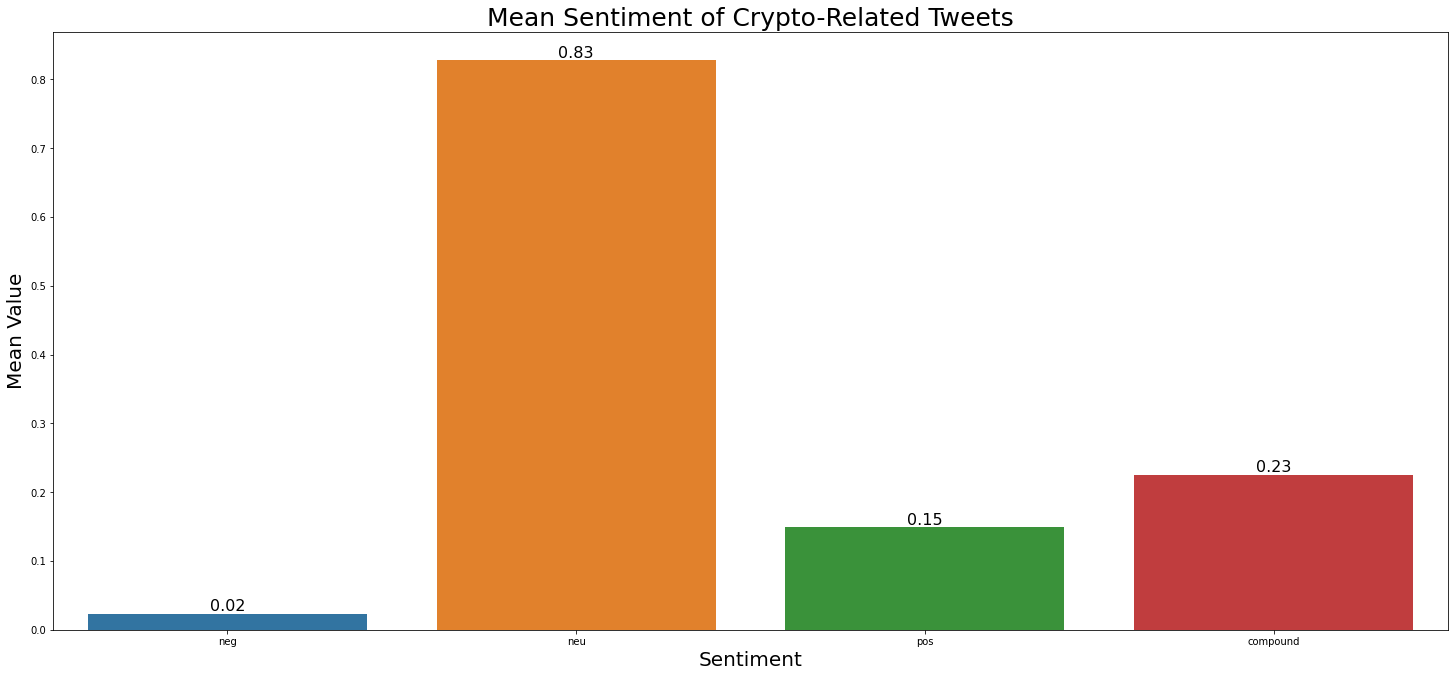

In [55]:
df_crypto = df[df['crypto related'] == 1]

# Plot
mean_values = df_crypto[['neg', 'neu', 'pos', 'compound']].mean()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.barplot(x=mean_values.index, y=mean_values.values)
plt.title("Mean Sentiment of Crypto-Related Tweets", size=25)
plt.xlabel("Sentiment", size=20)
plt.ylabel("Mean Value", size=20)

# Add annotations
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=16)

plt.show()

# We can see that Crypto-Related Tweets are on average more positive than negative. However, the majority of tweets don't seem to have a strong sentiment

In [35]:
print(df['CreatedAt'].min(), df['CreatedAt'].max())

2020-10-28 00:16:43+00:00 2021-05-16 05:56:47+00:00


In [36]:
df_crypto.to_csv("../../Data/QMEF/btc_tweet_analysis.csv", sep=";", encoding='utf8', index=0)
# Problems with encoding emojis.

In [62]:
pd.set_option('display.max_colwidth', None)
print(df_crypto['Text'])

0                                                                                                                                                                                                                                                         Cryptocurrency explained https://t.co/kUXaXx8a1R
0                                                                                                                                                                                                                                                 Heard a rumor some crypto coin was pegging the dollar 🤣🤣
0    @PeterSchiff An email saying you have gold is not the same as having gold. You might as well have crypto.  Money is just data that allows us to avoid the inconvenience of barter.  That data, like all data, is subject to latency &amp; error. The system will evolve to that which minimizes both.
0                                                                                                      